In [1]:
import pickle
import pandas as pd
from pathlib import Path
import gzip
from plotnine import *
from socialgene.clustermap.serialize import SerializeToClustermap
from socialgene.neo4j.neo4j import GraphDriver # grab the the neo4j connection
from socialgene.config import env_vars
env_vars["NEO4J_URI"] = "bolt://localhost:7687"

pickle_path ='BGC0000946.pickle.gz'
json_path = 'clinker.json'

In [2]:
# The pickle file is a serialized object that contains the search results from the SocialGene search engine results 
# from searching all of RefSeq for similar genetic regions to the BGC0000946 cluster.

with gzip.open(pickle_path, 'rb') as f:
    search_object = pickle.load(f)

In [3]:
df = search_object.link_df
df = df.groupby('target_gene_cluster').agg({'pident': ['mean', 'median', 'count']})
df.columns = ['_'.join(col).strip() for col in df.columns.values]
df=df[df.pident_count == len(search_object.input_bgc.features)]


In [4]:
search_object.link_df = search_object.link_df[search_object.link_df.target_gene_cluster.isin(df.reset_index(inplace=False).target_gene_cluster)]

In [5]:
temp = pd.merge(
            search_object._compare_bgcs_by_jaccard_and_levenshtein(),
            search_object._compare_bgcs_by_median_bitscore(),
            left_on="query_gene_cluster",
            right_on="target_gene_cluster",
            how="inner",
        )

In [6]:
df = pd.merge(df, temp, left_on='target_gene_cluster', right_on='query_gene_cluster_x', how='inner')
df = df.drop(columns=['query_gene_cluster_x', 'target_gene_cluster_x', 'query_gene_cluster_y'])
df.sort_values(by=["modscore", "score"], ascending=False, inplace=True)
df['query_bgc'] = search_object.input_bgc_id
df = df[['query_bgc','target_gene_cluster_y', 'pident_mean', 'pident_median', 'pident_count', 'levenshtein_include_internal_nonortholog','levenshtein_only_orthologs', 'percent_of_query', 'jaccard', 'modscore','score']]
df['target_nucleotide_sequence'] = df.target_gene_cluster_y.apply(lambda x: x.parent.external_id)
df['target_assembly'] = df.target_gene_cluster_y.apply(lambda x: x.parent.parent.uid)

In [7]:
df[df.target_assembly.str.startswith('BGC')]

,query_bgc,target_gene_cluster_y,pident_mean,pident_median,pident_count,levenshtein_include_internal_nonortholog,levenshtein_only_orthologs,percent_of_query,jaccard,modscore,score,target_nucleotide_sequence,target_assembly
5449,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,100.0,100.0,5,1.0,1.0,100,1.0,3.0,818.0,BGC0000946,BGC0000946
6652,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,95.96,96.5,5,1.0,1.0,100,1.0,3.0,791.0,BGC0000947,BGC0000947
6375,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,47.46,46.6,5,1.0,1.0,100,1.0,3.0,439.0,BGC0002527,BGC0002527
4437,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,46.78,46.0,5,1.0,1.0,100,1.0,3.0,392.0,BGC0001408,BGC0001408


RefSeq SocialGene database must be running for the following to work

In [8]:
df = df[(df.jaccard == 1) &  (df.levenshtein_include_internal_nonortholog == 1)].sort_values(by=["pident_median"], ascending=False, inplace=False).reset_index(drop=True)
df

,query_bgc,target_gene_cluster_y,pident_mean,pident_median,pident_count,levenshtein_include_internal_nonortholog,levenshtein_only_orthologs,percent_of_query,jaccard,modscore,score,target_nucleotide_sequence,target_assembly
0,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,100.0,100.0,5,1.0,1.0,100,1.0,3.0,818.0,BGC0000946,BGC0000946
1,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,99.6,99.5,5,1.0,1.0,100,1.0,3.0,818.0,NZ_JACXJH010000039.1,GCF_014705665.1
2,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,99.64,99.5,5,1.0,1.0,100,1.0,3.0,818.0,NZ_QRRY01000003.1,GCF_006382855.1
3,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,99.64,99.5,5,1.0,1.0,100,1.0,3.0,818.0,NZ_CAJOAR010000003.1,GCF_905331995.1
4,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,99.64,99.5,5,1.0,1.0,100,1.0,3.0,818.0,NZ_JAHXRT010000002.1,GCF_019429585.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6576,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,36.76,33.4,5,1.0,1.0,100,1.0,3.0,301.0,NZ_CP039186.1,GCF_009709335.1
6577,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,36.76,33.4,5,1.0,1.0,100,1.0,3.0,301.0,NZ_CP012413.1,GCF_000756435.2
6578,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,36.76,33.4,5,1.0,1.0,100,1.0,3.0,301.0,NZ_CP013762.1,GCF_001932735.1
6579,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,36.76,33.4,5,1.0,1.0,100,1.0,3.0,301.0,NZ_CP039181.1,GCF_009709315.1


In [9]:
# Get taxonomic information for the results from the database
with GraphDriver() as db:
        temp = db.run(
            f"""
        MATCH (a1:assembly)-[:IS_TAXON|TAXON_PARENT*1..]->(t1:taxid {{rank:'genus'}})
        WHERE a1.uid in $ids and t1.rank = 'genus'
        RETURN a1.uid as assembly,  t1.name as genus
        """, ids=list(set(df.target_assembly))
        ).to_df()


df=pd.merge(df, temp, left_on="target_assembly", right_on="assembly", how="left")

2024-08-16 13:35:40 INFO     Connected to Neo4j database at bolt://localhost:7687                                                          ]8;id=223263;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/neo4j/neo4j.py\neo4j.py]8;;\:]8;id=917984;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/neo4j/neo4j.py#61\61]8;;\

In [10]:
mibig_bgc_df=df[df.target_assembly.str.startswith('BGC')]

In [11]:
# modify so the plotting is more readable
mibig_bgc_df_labels = mibig_bgc_df.copy()
mibig_bgc_df_labels['index1'] = mibig_bgc_df_labels.index

mibig_bgc_df_labels.loc[mibig_bgc_df_labels.target_assembly=='BGC0000946', 'pident_median'] = mibig_bgc_df_labels[mibig_bgc_df_labels.target_assembly=='BGC0000946'].pident_median + 1.5
mibig_bgc_df_labels.loc[mibig_bgc_df_labels.target_assembly=='BGC0000946', 'index1'] = mibig_bgc_df_labels.loc[mibig_bgc_df_labels.target_assembly=='BGC0000946', 'index1'] + 200
mibig_bgc_df_labels.loc[mibig_bgc_df_labels.target_assembly=='BGC0000947', 'pident_median'] = mibig_bgc_df_labels[mibig_bgc_df_labels.target_assembly=='BGC0000947'].pident_median + 2.5
mibig_bgc_df_labels.loc[mibig_bgc_df_labels.target_assembly=='BGC0002527', 'pident_median'] = mibig_bgc_df_labels[mibig_bgc_df_labels.target_assembly=='BGC0002527'].pident_median -2
mibig_bgc_df_labels.loc[mibig_bgc_df_labels.target_assembly=='BGC0002527', 'index1'] = mibig_bgc_df_labels.loc[mibig_bgc_df_labels.target_assembly=='BGC0002527', 'index1'] - 500
mibig_bgc_df_labels.loc[mibig_bgc_df_labels.target_assembly=='BGC0001408', 'pident_median'] = mibig_bgc_df_labels[mibig_bgc_df_labels.target_assembly=='BGC0001408'].pident_median + 2
mibig_bgc_df_labels.loc[mibig_bgc_df_labels.target_assembly=='BGC0001408', 'index1'] = mibig_bgc_df_labels.loc[mibig_bgc_df_labels.target_assembly=='BGC0001408', 'index1'] + 200


In [12]:
mibig_bgc_df_labels

,query_bgc,target_gene_cluster_y,pident_mean,pident_median,pident_count,levenshtein_include_internal_nonortholog,levenshtein_only_orthologs,percent_of_query,jaccard,modscore,score,target_nucleotide_sequence,target_assembly,assembly,genus,index1
0,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,100.0,101.5,5,1.0,1.0,100,1.0,3.0,818.0,BGC0000946,BGC0000946,BGC0000946,Vibrio,200
2761,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,95.96,99.0,5,1.0,1.0,100,1.0,3.0,791.0,BGC0000947,BGC0000947,BGC0000947,Vibrio,2761
3566,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,47.46,44.6,5,1.0,1.0,100,1.0,3.0,439.0,BGC0002527,BGC0002527,NaN,NaN,3066
4032,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,46.78,48.0,5,1.0,1.0,100,1.0,3.0,392.0,BGC0001408,BGC0001408,NaN,NaN,4232


In [31]:
p=(
    ggplot() +
        geom_point(df, aes(x=range(0,len(df)), y="pident_median"), alpha=0.2) + 
        geom_point(mibig_bgc_df, aes(x=mibig_bgc_df.index.values.tolist(), y="pident_median"), color="red") + 
        geom_text(mibig_bgc_df_labels, aes(x=mibig_bgc_df_labels.index1, y="pident_median", label="target_assembly"), color="red", size = 12) + 
        ylab("Median identity of RBHs to BGC0000946") + 
        ggtitle("Protein similarity of BGCs syntenic to BGC0000946 (vibroferrin)") + 
        scale_y_continuous(breaks = range(0, 110, 10)) +
        theme(
            axis_title_x=element_blank(),
            axis_text_x=element_blank(),
            axis_ticks_x=element_blank(),
             axis_title_y=element_text(size = 13),
            #  plot_title = element_text(size = 14)
            ) + 
        coord_cartesian(ylim=[30,100])
)
p.save(filename = 'test3.svg')

/home/chase/miniconda3/envs/py312/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/chase/miniconda3/envs/py312/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: test3.svg


---

In [14]:
# genus is already in the dataframe, so we don't pull it in here
for x in ['species','family','order', 'class', 'phylum','superkingdom']:
    with GraphDriver() as db:
        
        temp = db.run(
            f"""
        MATCH (a1:assembly)-[:IS_TAXON|TAXON_PARENT*1..]->(t1:taxid {{rank:'{x}'}})
        WHERE a1.uid in $ids and t1.rank = '{x}'
        RETURN a1.uid as target_assembly,  t1.name as {x}
        """, ids=list(set(df.target_assembly))
        ).to_df()
        df = pd.merge(df, temp, on="target_assembly", how='left')


## Show the genome with the lowest median pident

In [15]:
df.sort_values(by=["pident_median"], ascending=False, inplace=False).iloc[-1]

query_bgc                                                                          BGC0000946
target_gene_cluster_y                       <socialgene.base.molbio.GeneCluster object at ...
pident_mean                                                                              35.1
pident_median                                                                            32.5
pident_count                                                                                5
levenshtein_include_internal_nonortholog                                                  1.0
levenshtein_only_orthologs                                                                1.0
percent_of_query                                                                          100
jaccard                                                                                   1.0
modscore                                                                                  3.0
score                                                       

In [16]:
# get the start/stop coordinates of the gene cluster with the lowest median pident
lowest_median_pident = search_object.link_df[search_object.link_df.target_gene_cluster == df.iloc[-1].target_gene_cluster_y]
min(i.start for i in lowest_median_pident.target_feature), max(i.end for i in lowest_median_pident.target_feature) 

(1773, 8967)

In [17]:

temp=df.sort_values(by=["pident_median"], ascending=False, inplace=False).tail(1)
assemblies = [search_object.input_assembly] + [i.parent.parent for i  in temp.target_gene_cluster_y.to_list()]
zz = SerializeToClustermap(
    sg_object=search_object.sg_object,
    sorted_bgcs=assemblies,
    link_df=search_object.link_df,
    group_df=search_object.group_df,
)
zz.write('/home/chase/Downloads/clinker-master(1)/clinker-master/clinker/plot/data.json')

2024-08-16 13:36:14 INFO     Writing clustermap.js output to:                                                                         ]8;id=947260;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py\serialize.py]8;;\:]8;id=93501;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py#140\140]8;;\
                             /home/chase/Downloads/clinker-master(1)/clinker-master/clinker/plot/data.json                                            

FileNotFoundError: [Errno 2] No such file or directory: '/home/chase/Downloads/clinker-master(1)/clinker-master/clinker/plot/data.json'

Show the genome with the lowest mean pident

In [ ]:
df.sort_values(by=["pident_mean"], ascending=False, inplace=False).iloc[-1]

query_bgc                                                                          BGC0000946
target_gene_cluster_y                       <socialgene.base.molbio.GeneCluster object at ...
pident_mean                                                                             34.04
pident_median                                                                            34.1
pident_count                                                                                5
levenshtein_include_internal_nonortholog                                                  1.0
levenshtein_only_orthologs                                                                1.0
percent_of_query                                                                          100
jaccard                                                                                   1.0
modscore                                                                                  3.0
score                                                       

Number of MIBiG BGCs in the results

In [ ]:
df[df.target_assembly.str.startswith('BGC')].target_assembly.nunique()

4

In [ ]:
df[~df.target_assembly.str.startswith('BGC')].nunique()

query_bgc                                      1
target_gene_cluster_y                       6577
pident_mean                                  709
pident_median                                220
pident_count                                   1
levenshtein_include_internal_nonortholog       1
levenshtein_only_orthologs                     1
percent_of_query                               1
jaccard                                        1
modscore                                       1
score                                        260
target_nucleotide_sequence                  6574
target_assembly                             6571
assembly                                    6571
genus                                         79
species                                      947
family                                        45
order                                         27
class                                          6
phylum                                         3
superkingdom        

In [ ]:
df.shape

(6581, 21)

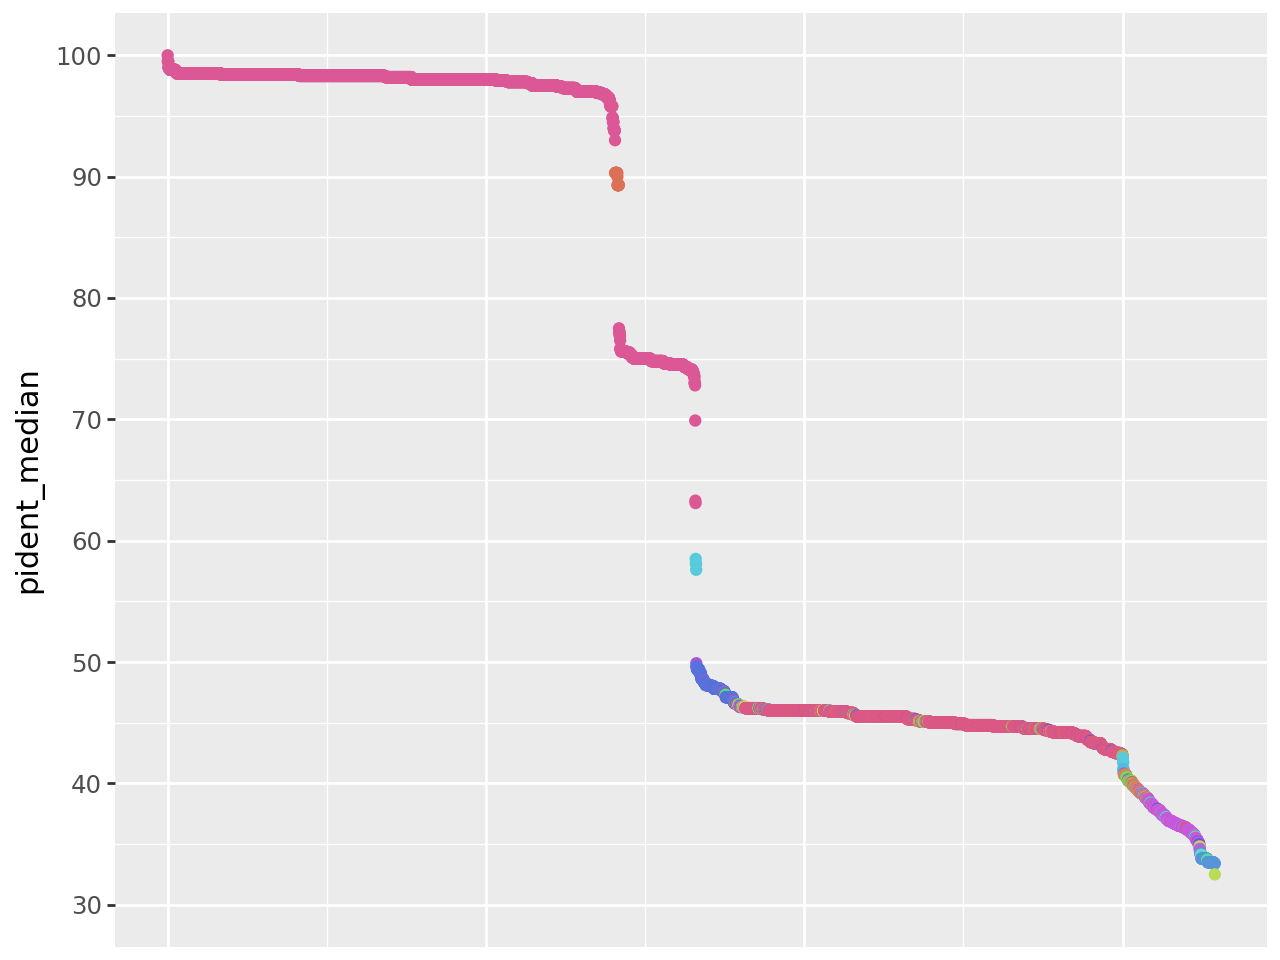

In [ ]:
(
    ggplot() +
        geom_point(df, aes(x=range(0,len(df)), y="pident_median", color="family")) +
        scale_y_continuous(breaks = range(0, 110, 10)) +
        theme(legend_position="none",
            axis_title_x=element_blank(),
            axis_text_x=element_blank(),
            axis_ticks_x=element_blank()) + 
        coord_cartesian(ylim=[30,100]) 
)

In [ ]:
df['start'] = df.target_gene_cluster_y.apply(lambda x: min(i.start for i in x.features))
df['end'] = df.target_gene_cluster_y.apply(lambda x: max(i.end for i in x.features))
df.to_csv('target_bgcs.tsv', sep='\t', index=False)

In [ ]:
df[df.target_nucleotide_sequence == "NZ_JAKKCM010000001.1"]

,query_bgc,target_gene_cluster_y,pident_mean,pident_median,pident_count,levenshtein_include_internal_nonortholog,levenshtein_only_orthologs,percent_of_query,jaccard,modscore,...,assembly,genus,species,family,order,class,phylum,superkingdom,start,end
2811,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,92.86,93.0,5,1.0,1.0,100,1.0,3.0,...,GCF_021728395.1,Vibrio,Vibrio sp. J1-1,Vibrionaceae,Vibrionales,Gammaproteobacteria,Pseudomonadota,Bacteria,460625,505716


In [ ]:
temp = df[(df.pident_median > 85) & (df.pident_median < 95)]

In [ ]:
assemblies = [search_object.input_assembly] + [i.parent.parent for i  in temp.target_gene_cluster_y.to_list()]

In [ ]:
for row in temp.iterrows():
    search_object.sg_object.assemblies.get(row[1].target_assembly).uid = f"{row[1].target_assembly}; {row[1].genus}"

In [ ]:

zz = SerializeToClustermap(
    sg_object=search_object.sg_object,
    sorted_bgcs=assemblies,
    link_df=search_object.link_df,
    group_df=search_object.group_df,
)
zz.write('/home/chase/Downloads/clinker-master(1)/clinker-master/clinker/plot/data.json')

                    INFO     Writing clustermap.js output to:                                                                         ]8;id=893849;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py\serialize.py]8;;\:]8;id=116087;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py#140\140]8;;\
                             /home/chase/Downloads/clinker-master(1)/clinker-master/clinker/plot/data.json                                            

                    INFO     Creating clustermap.js clusters                                                                           ]8;id=481528;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py\serialize.py]8;;\:]8;id=963738;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py#40\40]8;;\

                    INFO     Creating clustermap.js links                                                                             ]8;id=676987;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py\serialize.py]8;;\:]8;id=725617;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py#117\117]8;;\

2024-05-30 15:43:40 INFO     Creating clustermap.js links                                                                              ]8;id=879840;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py\serialize.py]8;;\:]8;id=92388;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py#92\92]8;;\

In [ ]:
temp=df[(df.pident_median > 55) & (df.pident_median < 60)]
assemblies = [search_object.input_assembly] + [i.parent.parent for i  in temp.target_gene_cluster_y.to_list()]
zz = SerializeToClustermap(
    sg_object=search_object.sg_object,
    sorted_bgcs=assemblies,
    link_df=search_object.link_df,
    group_df=search_object.group_df,
)
zz.write('/home/chase/Downloads/clinker-master(1)/clinker-master/clinker/plot/data.json')

                    INFO     Writing clustermap.js output to:                                                                         ]8;id=815690;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py\serialize.py]8;;\:]8;id=631376;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py#140\140]8;;\
                             /home/chase/Downloads/clinker-master(1)/clinker-master/clinker/plot/data.json                                            

                    INFO     Creating clustermap.js clusters                                                                           ]8;id=853577;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py\serialize.py]8;;\:]8;id=35422;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py#40\40]8;;\

                    INFO     Creating clustermap.js links                                                                             ]8;id=455686;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py\serialize.py]8;;\:]8;id=454053;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py#117\117]8;;\

2024-05-30 15:43:41 INFO     Creating clustermap.js links                                                                              ]8;id=571709;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py\serialize.py]8;;\:]8;id=63342;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py#92\92]8;;\

In [ ]:
temp

,query_bgc,target_gene_cluster_y,pident_mean,pident_median,pident_count,levenshtein_include_internal_nonortholog,levenshtein_only_orthologs,percent_of_query,jaccard,modscore,...,assembly,genus,species,family,order,class,phylum,superkingdom,start,end
3318,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,58.54,58.5,5,1.0,1.0,100,1.0,3.0,...,GCF_003259175.1,Marinomonas,Marinomonas shanghaiensis,Oceanospirillaceae,Oceanospirillales,Gammaproteobacteria,Pseudomonadota,Bacteria,14270,43951
3319,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,59.1,58.1,5,1.0,1.0,100,1.0,3.0,...,GCF_900089755.1,Marinomonas,Marinomonas aquimarina,Oceanospirillaceae,Oceanospirillales,Gammaproteobacteria,Pseudomonadota,Bacteria,1,32606
3320,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,59.1,58.1,5,1.0,1.0,100,1.0,3.0,...,GCF_001639695.1,Marinomonas,Marinomonas aquimarina,Oceanospirillaceae,Oceanospirillales,Gammaproteobacteria,Pseudomonadota,Bacteria,1,32556
3321,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,58.14,57.6,5,1.0,1.0,100,1.0,3.0,...,GCF_016461715.1,Marinomonas,Marinomonas spartinae,Oceanospirillaceae,Oceanospirillales,Gammaproteobacteria,Pseudomonadota,Bacteria,243166,286703


Find which target BGCs are on nucleotide sequences annotated in RefSeq as plasmids

In [ ]:
with GraphDriver() as db:
    temp2 = db.run(
        """
    MATCH (n1:nucleotide)
    WHERE n1.external_id in $ids AND n1.plasmid is not null
    RETURN n1.external_id as target_nucleotide_sequence, n1.plasmid as plasmid, 'true' as plasmid_truthy
    """, ids=list(set(df.target_nucleotide_sequence))
    ).to_df()


In [ ]:
temp2

,target_nucleotide_sequence,plasmid,plasmid_truthy
0,NZ_LT991977.1,II,true
1,NZ_PEBY01000001.1,Xcm-LG56-10-G1-Mol001,true
2,NZ_LT984807.1,II,true
3,NZ_CP066020.1,unnamed,true
4,NC_005241.1,megaplasmid pHG1,true
5,NZ_CP032703.1,unnamed1,true
6,NZ_CP046573.1,pRWAY01,true
7,NZ_CP039041.1,unnamed1,true
8,NZ_CP021356.1,pRB29,true
9,NZ_CP039289.1,pHG1,true


In [ ]:
tempdf = df.merge(temp2, left_on='target_nucleotide_sequence', right_on='target_nucleotide_sequence', how='left')

In [ ]:
tempdf

,query_bgc,target_gene_cluster_y,pident_mean,pident_median,pident_count,levenshtein_include_internal_nonortholog,levenshtein_only_orthologs,percent_of_query,jaccard,modscore,...,species,family,order,class,phylum,superkingdom,start,end,plasmid,plasmid_truthy
0,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,100.0,100.0,5,1.0,1.0,100,1.0,3.0,...,Vibrio parahaemolyticus,Vibrionaceae,Vibrionales,Gammaproteobacteria,Pseudomonadota,Bacteria,283,7531,NaN,NaN
1,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,99.6,99.5,5,1.0,1.0,100,1.0,3.0,...,Vibrio parahaemolyticus,Vibrionaceae,Vibrionales,Gammaproteobacteria,Pseudomonadota,Bacteria,51006,96169,NaN,NaN
2,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,99.64,99.5,5,1.0,1.0,100,1.0,3.0,...,Vibrio parahaemolyticus,Vibrionaceae,Vibrionales,Gammaproteobacteria,Pseudomonadota,Bacteria,207705,252868,NaN,NaN
3,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,99.64,99.5,5,1.0,1.0,100,1.0,3.0,...,Vibrio parahaemolyticus,Vibrionaceae,Vibrionales,Gammaproteobacteria,Pseudomonadota,Bacteria,207705,252868,NaN,NaN
4,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,99.64,99.5,5,1.0,1.0,100,1.0,3.0,...,Vibrio parahaemolyticus,Vibrionaceae,Vibrionales,Gammaproteobacteria,Pseudomonadota,Bacteria,300686,345850,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6576,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,36.76,33.4,5,1.0,1.0,100,1.0,3.0,...,Piscirickettsia salmonis,Piscirickettsiaceae,Thiotrichales,Gammaproteobacteria,Pseudomonadota,Bacteria,1396774,1441249,NaN,NaN
6577,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,36.76,33.4,5,1.0,1.0,100,1.0,3.0,...,Piscirickettsia salmonis,Piscirickettsiaceae,Thiotrichales,Gammaproteobacteria,Pseudomonadota,Bacteria,1611449,1655924,NaN,NaN
6578,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,36.76,33.4,5,1.0,1.0,100,1.0,3.0,...,Piscirickettsia salmonis,Piscirickettsiaceae,Thiotrichales,Gammaproteobacteria,Pseudomonadota,Bacteria,2873267,2917741,NaN,NaN
6579,BGC0000946,<socialgene.base.molbio.GeneCluster object at ...,36.76,33.4,5,1.0,1.0,100,1.0,3.0,...,Piscirickettsia salmonis,Piscirickettsiaceae,Thiotrichales,Gammaproteobacteria,Pseudomonadota,Bacteria,1396726,1441201,NaN,NaN


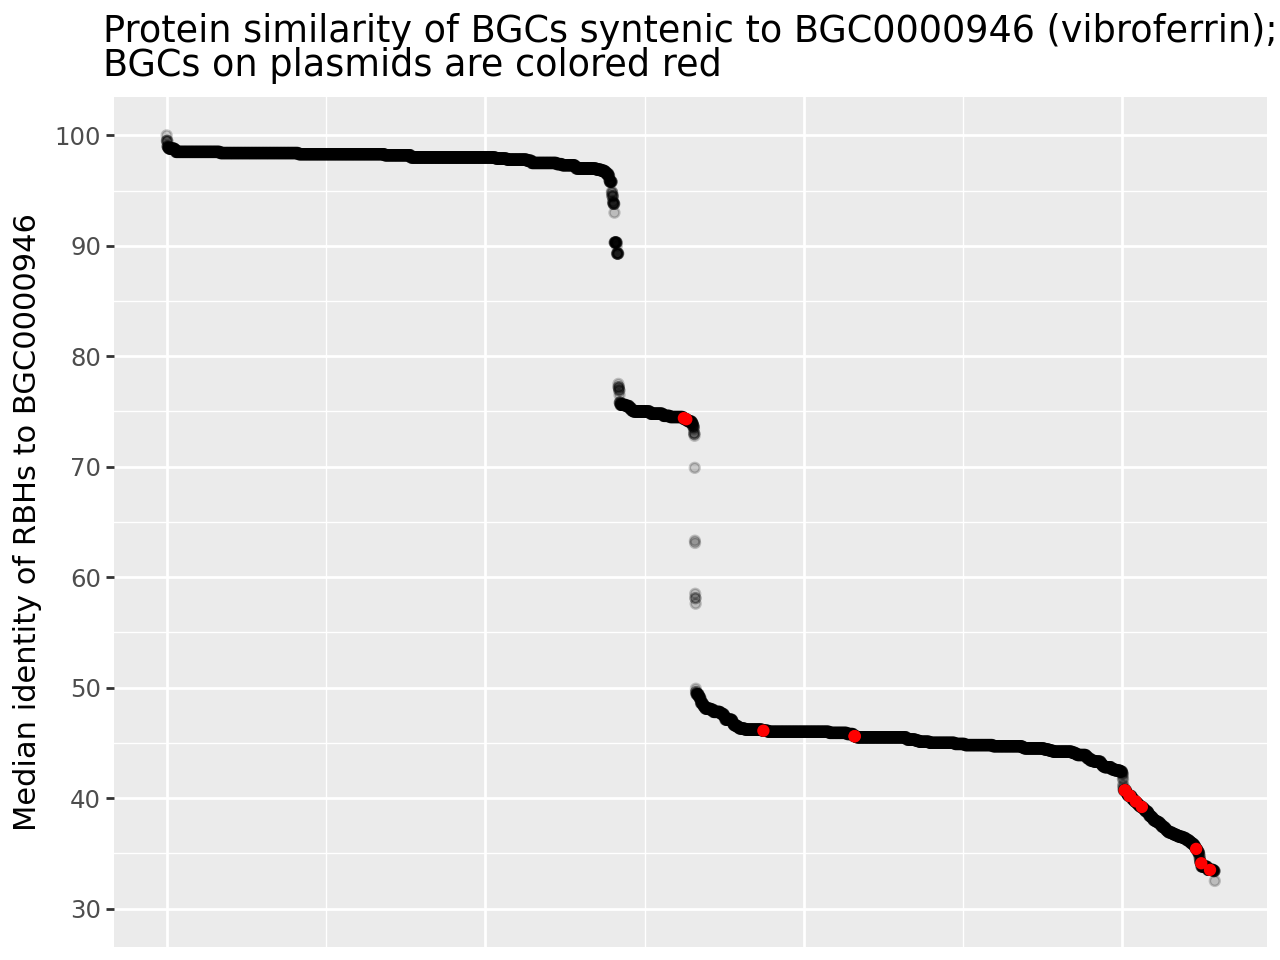

In [ ]:
(
    ggplot() +
        geom_point(df, aes(x=range(0,len(df)), y="pident_median"), alpha=0.2) + 
        geom_point(tempdf[tempdf.plasmid_truthy == 'true'], aes(x=tempdf[tempdf.plasmid_truthy == 'true'].index.tolist(), y="pident_median"), color="red") +
        ylab("Median identity of RBHs to BGC0000946") + 
        ggtitle("Protein similarity of BGCs syntenic to BGC0000946 (vibroferrin);\nBGCs on plasmids are colored red") + 
        scale_y_continuous(breaks = range(0, 110, 10)) +
        theme(
            axis_title_x=element_blank(),
            axis_text_x=element_blank(),
            axis_ticks_x=element_blank()) + 
        coord_cartesian(ylim=[30,100])
)

In [ ]:
temp = tempdf[tempdf.plasmid == 'true']
for row in temp.iterrows():
    search_object.sg_object.assemblies.get(row[1].target_assembly).uid = f"{row[1].target_assembly}; {row[1].genus}"

In [ ]:

assemblies = [search_object.input_assembly] + [i.parent.parent for i  in temp.target_gene_cluster_y.to_list()]
zz = SerializeToClustermap(
    sg_object=search_object.sg_object,
    sorted_bgcs=assemblies,
    link_df=search_object.link_df,
    group_df=search_object.group_df,
)
zz.write('/home/chase/Downloads/clinker-master(1)/clinker-master/clinker/plot/data.json')

2024-05-30 15:43:42 INFO     Writing clustermap.js output to:                                                                         ]8;id=327803;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py\serialize.py]8;;\:]8;id=982884;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py#140\140]8;;\
                             /home/chase/Downloads/clinker-master(1)/clinker-master/clinker/plot/data.json                                            

                    INFO     Creating clustermap.js clusters                                                                           ]8;id=795460;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py\serialize.py]8;;\:]8;id=560516;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py#40\40]8;;\

                    INFO     Creating clustermap.js links                                                                             ]8;id=170850;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py\serialize.py]8;;\:]8;id=132013;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py#117\117]8;;\

2024-05-30 15:43:43 INFO     Creating clustermap.js links                                                                              ]8;id=706332;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py\serialize.py]8;;\:]8;id=816840;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/clustermap/serialize.py#92\92]8;;\